# Gold Layer: Scoperta dei Cluster con K-Means

Questo notebook rappresenta la fase finale e più importante del nostro progetto: il **Gold Layer**. L'obiettivo è passare da una descrizione dettagliata dei dati (il Silver Layer) a una vera e propria **scoperta di conoscenza** attraverso il machine learning.

Partendo dalla tabella `profili_stazioni_silver`, che contiene la "carta d'identità" di ogni stazione di monitoraggio, useremo un algoritmo di clustering non supervisionato (K-Means) per rispondere alla nostra domanda di ricerca principale:

> **Esistono "famiglie" o categorie naturali di stazioni con profili comportamentali statisticamente simili? Se sì, cosa le caratterizza?**

Il processo si articolerà in tre macro-fasi:
1.  **Preparazione dei Dati:** Selezione e normalizzazione delle feature per prepararle all'analisi.
2.  **Ricerca del K Ottimale:** Esecuzione di un esperimento per determinare il numero di cluster più appropriato per i nostri dati.
3.  **Addestramento e Interpretazione:** Creazione del modello finale, assegnazione delle etichette di cluster e analisi qualitativa dei gruppi scoperti.

---
## Fase 1: Setup dell'Ambiente e Caricamento dei Dati

Come primo passo, importiamo tutte le librerie necessarie per l'analisi, il machine learning e la visualizzazione. Configuriamo poi la connessione a MinIO S3 per caricare la tabella `profili_stazioni_silver`, che costituisce il punto di partenza per tutta la nostra analisi. Infine, impostiamo la connessione al server MLflow per essere pronti a tracciare i nostri esperimenti.

In [5]:
import pandas as pd
import numpy as np
from deltalake import DeltaTable
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

import mlflow

import os
from dotenv import load_dotenv

load_dotenv()

print("Inizio Fase 1: Setup e Caricamento Dati Silver...")

# Credenziali e configurazione per accedere a MinIO S3
storage_options = { 
    "AWS_ACCESS_KEY_ID": os.getenv("AWS_ACCESS_KEY_ID"),                
    "AWS_SECRET_ACCESS_KEY": os.getenv("AWS_SECRET_ACCESS_KEY"), 
    "AWS_ENDPOINT_URL": os.getenv("AWS_ENDPOINT_URL"), 
    "AWS_ALLOW_HTTP": "true" 
}

IS_REMOTE = os.getenv("IS_REMOTE", 'false').lower() == 'true'
TABLE_SILVER = "profili_stazioni_silver"

REMOTE_BASE_PATH = "s3a://external/"
LOCAL_BASE_PATH = "../delta_tables/"

# SETUP DI MLFLOW: Diciamo al codice dove si trova il "diario di laboratorio"
#mlflow.set_tracking_uri("http://192.168.41.139:5000")
# Creiamo un "capitolo" del diario per i nostri esperimenti di clustering
#mlflow.set_experiment("Clustering Profili Stazioni ARPAE")

df_profiles = None

# Carichiamo la tabella Silver che abbiamo creato prima
try:

    if IS_REMOTE:
        print(f"Modalità Remota: Caricamento dati da S3 ({REMOTE_BASE_PATH})...")
        df_profiles = DeltaTable(f"{REMOTE_BASE_PATH}{TABLE_SILVER}", storage_options=storage_options).to_pandas()
    else:
        print(f"Modalità Locale: Caricamento dati da cartella locale ({LOCAL_BASE_PATH})...")
        df_profiles = DeltaTable(f"{LOCAL_BASE_PATH}{TABLE_SILVER}", storage_options=storage_options).to_pandas()

    # Usiamo l'id_stazione come indice per facilitare la manipolazione
    df_profiles.set_index('id_stazione', inplace=True)
    print(f"Tabella Silver caricata con successo. Contiene {len(df_profiles)} profili di stazioni.")
    display(df_profiles.head())
except Exception as e:
    print(f"ERRORE CRITICO: Impossibile caricare la tabella Silver. Dettagli: {e}")

Inizio Fase 1: Setup e Caricamento Dati Silver...
Modalità Locale: Caricamento dati da cartella locale (../delta_tables/)...
Tabella Silver caricata con successo. Contiene 54 profili di stazioni.


,mean_C6H4CH32_o-xylene,mean_C6H5-CH3_Toluene,mean_C6H6_Benzene,mean_CO_Monossido_di_carbonio,mean_NO_Monossido_di_azoto,mean_NO2_Biossido_di_azoto,mean_NOX_Ossidi_di_azoto,mean_O3_Ozono,mean_PM10,mean_PM2.5,...,stazioni_vicine_20km,Stazione,COMUNE,PROVINCIA,Coord_X,Coord_Y,LON_GEO,LAT_GEO,Tipo_Area,__index_level_0__
id_stazione,,,,,,,,,,,,,,,,,,,,,
2000003,0.0,0.0,0.00000,0.000000,0.00000,22.437266,0.000000,48.415908,30.988562,18.631970,...,6.0,CITTADELLA,PARMA,PR,605202.8081,4.960646e+06,10.329985,44.791470,Capoluogo,0
2000004,0.0,0.0,1.26683,0.576071,23.22266,34.960309,70.461833,0.000000,32.823860,0.000000,...,6.0,MONTEBELLO,PARMA,PR,605647.7945,4.960011e+06,10.335478,44.785689,Capoluogo,1
2000214,0.0,0.0,0.00000,0.000000,0.00000,12.692230,0.000000,60.243845,19.953866,13.223706,...,2.0,BADIA,LANGHIRANO,PR,602146.6249,4.945686e+06,10.288366,44.657269,Provincia,2
2000219,0.0,0.0,0.00000,0.000000,7.75449,18.729459,30.670067,45.170070,28.067987,19.502072,...,5.0,SARAGAT,COLORNO,PR,608189.9804,4.975535e+06,10.370915,44.925020,Provincia,3
2000229,0.0,0.0,0.00000,0.000000,0.00000,19.087045,0.000000,0.000000,29.272364,19.753922,...,5.0,MALCANTONE,MEZZANI,PR,610442.9141,4.971681e+06,10.398613,44.889990,Provincia,4


---
## Fase 2: Preparazione dei Dati per il Machine Learning

Un algoritmo come K-Means non può lavorare direttamente sui dati grezzi della tabella Silver. Dobbiamo eseguire due passaggi di pre-processing fondamentali per garantirne il corretto funzionamento:

1.  **Selezione delle Feature:** Isoleremo solo le colonne numeriche che rappresentano le caratteristiche comportamentali delle stazioni (es. `media_PM10`, `rapporto_feriale_festivo_NO2`, etc.). Le colonne contenenti metadati descrittivi (come `Stazione`, `COMUNE`) verranno escluse da questa fase, poiché l'algoritmo non può interpretarle.

2.  **Normalizzazione:** Questo è il passaggio tecnico più critico. Le nostre feature si trovano su scale molto diverse (una media di PM10 può valere 40, mentre una correlazione è compresa tra -1 e 1). Per evitare che l'algoritmo sia "influenzato" dalle feature con valori numerici più grandi, applicheremo una normalizzazione `MinMaxScaler`. Questo processo "schiaccia" tutte le feature in un intervallo comune (da 0 a 1), garantendo che ognuna di esse abbia la stessa opportunità di influenzare il risultato finale.

Inoltre, cosiderando che abbiamo tanti inquinanti, scelgo 3 inquinanti come core set che permettono di verificare la qualità dell'aria per la pericolosità. Quelli scelti sono: PM2.5, PM10 e NO2

In [6]:
print("\nInizio Fase 2: Preparazione dei dati per il ML...")
# elimino la colonna __index_level_0__ che non serve
if '__index_level_0__' in df_profiles.columns:
    df_profiles.drop(columns=['__index_level_0__'], inplace=True)
    print("Colonna '__index_level_0__' rimossa.")


print("[Passo 2.1] Identificazione del 'Core Set' di Stazioni Omogenee...")

# --- FASE A: FILTRAGGIO DELLE STAZIONI ---
# 2. Definisci gli inquinanti "core" che ogni stazione DEVE misurare
core_pollutants_names = ['PM2.5', 'PM10', 'NO2_Biossido_di_azoto'] 
core_mean_cols = [f'mean_{name}' for name in core_pollutants_names if f'mean_{name}' in df_profiles.columns]
print(f"\nInquinanti 'core' scelti: {core_pollutants_names}")

# 3. Filtra df_profiles per tenere solo le stazioni che misurano TUTTI gli inquinanti core
mask_core_stations = (df_profiles[core_mean_cols] > 0).all(axis=1)
df_filtered_profiles = df_profiles[mask_core_stations].copy() # DataFrame intermedio con solo stazioni valide
display(df_filtered_profiles)
print(f"\nNumero stazioni totali: {len(df_profiles)}")
print(f"Numero stazioni nel 'Core Set': {len(df_filtered_profiles)}")


Inizio Fase 2: Preparazione dei dati per il ML...
Colonna '__index_level_0__' rimossa.
[Passo 2.1] Identificazione del 'Core Set' di Stazioni Omogenee...

Inquinanti 'core' scelti: ['PM2.5', 'PM10', 'NO2_Biossido_di_azoto']


,mean_C6H4CH32_o-xylene,mean_C6H5-CH3_Toluene,mean_C6H6_Benzene,mean_CO_Monossido_di_carbonio,mean_NO_Monossido_di_azoto,mean_NO2_Biossido_di_azoto,mean_NOX_Ossidi_di_azoto,mean_O3_Ozono,mean_PM10,mean_PM2.5,...,giorni_superamento_soglia_PM10,stazioni_vicine_20km,Stazione,COMUNE,PROVINCIA,Coord_X,Coord_Y,LON_GEO,LAT_GEO,Tipo_Area
id_stazione,,,,,,,,,,,,,,,,,,,,,
2000003,0.0,0.0,0.000000,0.000000,0.000000,22.437266,0.000000,48.415908,30.988562,18.631970,...,678.0,6.0,CITTADELLA,PARMA,PR,605202.8081,4.960646e+06,10.329985,44.791470,Capoluogo
2000214,0.0,0.0,0.000000,0.000000,0.000000,12.692230,0.000000,60.243845,19.953866,13.223706,...,163.0,2.0,BADIA,LANGHIRANO,PR,602146.6249,4.945686e+06,10.288366,44.657269,Provincia
2000219,0.0,0.0,0.000000,0.000000,7.754490,18.729459,30.670067,45.170070,28.067987,19.502072,...,437.0,5.0,SARAGAT,COLORNO,PR,608189.9804,4.975535e+06,10.370915,44.925020,Provincia
2000229,0.0,0.0,0.000000,0.000000,0.000000,19.087045,0.000000,0.000000,29.272364,19.753922,...,195.0,5.0,MALCANTONE,MEZZANI,PR,610442.9141,4.971681e+06,10.398613,44.889990,Provincia
2000230,0.0,0.0,0.000000,0.000000,0.000000,27.160470,0.000000,0.000000,27.712813,19.272905,...,191.0,5.0,BOGOLESE,SORBOLO,PR,609922.8330,4.964806e+06,10.390539,44.828198,Provincia
2000232,0.0,0.0,0.699858,0.000000,0.000000,31.835557,0.000000,0.000000,28.202264,19.278785,...,186.0,5.0,PARADIGNA,PARMA,PR,606187.8848,4.966091e+06,10.343573,44.840328,Capoluogo
3000001,0.0,0.0,0.000000,0.000000,5.962973,18.703239,27.750042,50.783808,26.100019,18.112313,...,437.0,3.0,CASTELLARANO,CASTELLARANO,RE,637727.4852,4.930568e+06,10.732918,44.515287,Provincia
3000007,0.0,0.0,0.000000,0.000000,11.693842,22.947082,40.679696,46.092798,28.271765,19.087838,...,556.0,3.0,S. LAZZARO,REGGIO NELL'EMILIA,RE,631747.5665,4.949647e+06,10.662600,44.688092,Capoluogo
3000022,0.0,0.0,0.000000,0.000000,7.441172,17.648445,28.969209,47.318107,29.772045,20.484278,...,580.0,2.0,S. ROCCO,GUASTALLA,RE,631421.7040,4.970165e+06,10.663785,44.872785,Provincia



Numero stazioni totali: 54
Numero stazioni nel 'Core Set': 26


# Pulizia delle colonne
Dopo aver rimosso le righe che non ci interessano divido il dataframe in 2 parti, una con metadati e una con soli valori. 

Tratto 'giorni_superamento_soglia_PM10' e 'stazioni_vicine_20km' come metadati perchè li userò comunque per una validazione a posteriori

In [7]:
print("\n[Passo 2.2] Separazione in DataFrame 'df_metadata' e 'df_core'...")

# 1. Definisci le colonne di metadati
metadata_cols = [
    'giorni_superamento_soglia_PM10', 'stazioni_vicine_20km', 'Stazione', 'COMUNE', 
    'PROVINCIA', 'Coord_X', 'Coord_Y', 'LON_GEO', 'LAT_GEO', 'Tipo_Area'
]
# Assicuriamoci di usare solo metadati che esistono effettivamente nel dataframe
metadata_cols_existing = [col for col in metadata_cols if col in df_filtered_profiles.columns]

# 2. Crea il DataFrame dei metadati
# Selezioniamo solo le colonne di metadati dal set di stazioni filtrate.
# L'indice 'id_stazione' viene ereditato automaticamente.
df_metadata = df_filtered_profiles[metadata_cols_existing].copy()

# 3. Identifica e seleziona le colonne relative ai "core pollutants"
# Questa è la logica chiave: una colonna è rilevante se il suo nome TERMINA
# con uno degli inquinanti del nostro "core set".
core_data_cols = [
    col for col in df_filtered_profiles.columns 
    if any(col.endswith(pollutant) and col != 'giorni_superamento_soglia_PM10' for pollutant in core_pollutants_names)
]


# 4. Crea il DataFrame 'df_core' con solo i dati degli inquinanti scelti
df_core = df_filtered_profiles[core_data_cols].copy()

# --- VERIFICA FINALE ---

print("\n--- Risultati della Trasformazione ---")
print("\n✅ df_metadata: Contiene i metadati per le stazioni del 'Core Set'.")
# display(df_metadata.head())
print(df_metadata.info())


print("\n✅ df_core: Contiene SOLO i dati relativi agli inquinanti 'core' per le stazioni filtrate.")
print(df_core.info())
display(df_core)


[Passo 2.2] Separazione in DataFrame 'df_metadata' e 'df_core'...

--- Risultati della Trasformazione ---

✅ df_metadata: Contiene i metadati per le stazioni del 'Core Set'.
<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 2000003 to 10000002
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   giorni_superamento_soglia_PM10  26 non-null     float64
 1   stazioni_vicine_20km            26 non-null     float64
 2   Stazione                        26 non-null     object 
 3   COMUNE                          26 non-null     object 
 4   PROVINCIA                       26 non-null     object 
 5   Coord_X                         26 non-null     float64
 6   Coord_Y                         26 non-null     float64
 7   LON_GEO                         26 non-null     float64
 8   LAT_GEO                         26 non-null     float64
 9   Tipo_Area                       26 non-

,mean_NO2_Biossido_di_azoto,mean_PM10,mean_PM2.5,std_NO2_Biossido_di_azoto,std_PM10,std_PM2.5,rapporto_feriale_festivo_PM10,rapporto_feriale_festivo_NO2_Biossido_di_azoto,rapporto_feriale_festivo_PM2.5,mean_autunno_NO2_Biossido_di_azoto,...,mean_inverno_NO2_Biossido_di_azoto,mean_primavera_NO2_Biossido_di_azoto,mean_autunno_PM10,mean_estate_PM10,mean_inverno_PM10,mean_primavera_PM10,mean_autunno_PM2.5,mean_estate_PM2.5,mean_inverno_PM2.5,mean_primavera_PM2.5
id_stazione,,,,,,,,,,,,,,,,,,,,,
2000003,22.437266,30.988562,18.631970,16.471274,18.155375,15.084762,1.009829,1.198516,0.983267,24.273767,...,36.762280,17.767966,32.879245,23.310801,43.009420,24.993759,19.078818,10.470313,31.873328,13.470194
2000214,12.692230,19.953866,13.223706,10.544768,12.779741,10.524234,1.005474,1.209915,0.978033,13.312654,...,21.720591,9.585709,20.646480,16.338921,26.463683,16.572829,13.499619,9.173147,20.003658,10.337781
2000219,18.729459,28.067987,19.502072,12.418194,16.342715,13.869229,0.998481,1.196163,0.986428,19.561270,...,29.681141,14.752347,29.781991,20.116531,40.264050,22.306299,20.348684,12.195848,31.654356,14.449821
2000229,19.087045,29.272364,19.753922,12.716073,16.553044,12.934635,1.011189,1.255799,0.976482,19.821583,...,31.379075,14.429225,32.111524,21.506518,39.285106,24.747807,21.732342,13.449541,29.010638,15.689938
2000230,27.160470,27.712813,19.272905,19.449806,16.969883,13.421065,1.012269,1.281440,0.985334,28.116014,...,40.733575,23.332719,30.774436,18.972376,39.675159,22.586558,21.363296,12.145221,29.468220,15.095723
2000232,31.835557,28.202264,19.278785,20.989573,16.606724,13.179834,1.062470,1.381876,1.006424,32.870994,...,43.291217,28.932456,31.673546,19.611321,39.174004,23.058943,21.425094,12.378731,28.968619,15.060852
3000001,18.703239,26.100019,18.112313,13.378588,16.381568,14.192211,1.046400,1.264505,0.993804,19.796250,...,29.880356,15.982891,27.947581,18.031177,38.309524,20.313146,18.739001,10.206946,30.605511,13.168858
3000007,22.947082,28.271765,19.087838,16.390711,16.892722,14.073978,1.029030,1.234419,0.985764,24.511323,...,35.358949,18.883830,30.186584,20.090170,40.203610,22.773546,19.704388,11.503682,30.933140,14.374913
3000022,17.648445,29.772045,20.484278,12.678405,17.554142,15.805201,1.015092,1.185974,0.986963,18.536036,...,28.885735,12.731719,30.827614,22.916406,41.991545,23.562500,20.396513,12.271049,33.978166,15.351370


## Preparazione e normalizzazione dei dati

In [15]:
print("[Passo 3] Preparazione Dati Comportamentali per il Clustering...")

# df_core contiene le 21 feature che useremo
# L'indice 'id_stazione' viene gestito correttamente e non è incluso nei calcoli

# Inizializziamo e applichiamo lo StandardScaler
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()
X_scaled_core_std = scaler_std.fit_transform(df_core)
X_scaled_core_mm = scaler_mm.fit_transform(df_core)

print(f"Matrice di feature standardizzata. Dimensioni std: {X_scaled_core_std.shape}     Dimensioni minmax:{X_scaled_core_mm.shape}")
#print(X_scaled_core.info())
#display(X_scaled_core)
print("I dati sono pronti per la ricerca del K ottimale.")
print("\nPasso 3 completato.")

[Passo 3] Preparazione Dati Comportamentali per il Clustering...
Matrice di feature standardizzata. Dimensioni std: (26, 21)     Dimensioni minmax:(26, 21)
I dati sono pronti per la ricerca del K ottimale.

Passo 3 completato.


---
## Fase 3: Ricerca del Numero Ottimale di Cluster (K)

La sfida principale dell'algoritmo K-Means è che dobbiamo specificare a priori il numero di cluster `K` da cercare. Scegliere un valore di `K` a caso non è un approccio scientifico.

Per prendere una decisione informata, eseguiremo un esperimento sistematico: testeremo una serie di valori di `K` (ad esempio, da 2 a 10) e valuteremo la qualità dei risultati usando due metriche standard:

*   **Metodo del Gomito (Elbow Method):** Misura la compattezza totale dei cluster attraverso un valore chiamato "Inertia". Cercheremo il "gomito", ovvero il punto nel grafico in cui aggiungere un nuovo cluster non porta più a un miglioramento significativo.

*   **Punteggio di Silhouette (Silhouette Score):** Misura la qualità complessiva dei cluster, valutando quanto ogni punto sia simile al proprio cluster rispetto agli altri. Un punteggio più vicino a 1 indica cluster densi e ben separati. Cercheremo il valore di `K` che massimizza questo punteggio.

Il codice seguente eseguirà questo ciclo di test e memorizzerà i risultati per la visualizzazione.

In [19]:
# ===================================================================
# FASE 3: ESPERIMENTO PER TROVARE IL K OTTIMALE
# ===================================================================
print("\n[Passo 3] Ricerca del K Ottimale (su Dati a 21 Dimensioni)...")

# Dato che hai solo 26 stazioni, testiamo un range di K più piccolo
k_range = range(2, 10)
inertias_std = []
silhouette_scores_std = []

inertias_mm = []
silhouette_scores_mm = []

print("\n-------Test su standard scaler-------")

for k in k_range:
    # Usiamo n_init='auto' o 10 per evitare warning futuri
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_core_std) # ADDESTRIAMO SUI DATI COMPLETI
    inertias_std.append(kmeans.inertia_)
    silhouette_scores_std.append(silhouette_score(X_scaled_core_std, kmeans.labels_))
    # Stampiamo un feedback per ogni passo del ciclo, così vediamo il progresso.
    print(f"Testato K={k}: Inertia = {inertias_std[-1]:.2f}, Silhouette Score = {silhouette_scores_std[-1]:.4f}")

print("\n-------Test su minmax scaler-------")

for k in k_range:
    # Usiamo n_init='auto' o 10 per evitare warning futuri
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_core_mm) # ADDESTRIAMO SUI DATI COMPLETI
    inertias_mm.append(kmeans.inertia_)
    silhouette_scores_mm.append(silhouette_score(X_scaled_core_mm, kmeans.labels_))
    # Stampiamo un feedback per ogni passo del ciclo, così vediamo il progresso.
    print(f"Testato K={k}: Inertia = {inertias_mm[-1]:.2f}, Silhouette Score = {silhouette_scores_mm[-1]:.4f}")

print("\nRicerca completata. Ora siamo pronti a visualizzare i risultati per scegliere il K definitivo.")


[Passo 3] Ricerca del K Ottimale (su Dati a 21 Dimensioni)...

-------Test su standard scaler-------
Testato K=2: Inertia = 349.87, Silhouette Score = 0.6294
Testato K=3: Inertia = 228.37, Silhouette Score = 0.3016
Testato K=4: Inertia = 162.32, Silhouette Score = 0.2562
Testato K=5: Inertia = 139.81, Silhouette Score = 0.1930
Testato K=6: Inertia = 115.73, Silhouette Score = 0.1687
Testato K=7: Inertia = 93.14, Silhouette Score = 0.1574
Testato K=8: Inertia = 76.72, Silhouette Score = 0.1868
Testato K=9: Inertia = 65.47, Silhouette Score = 0.1989

-------Test su minmax scaler-------
Testato K=2: Inertia = 14.57, Silhouette Score = 0.5997
Testato K=3: Inertia = 9.17, Silhouette Score = 0.3441
Testato K=4: Inertia = 6.78, Silhouette Score = 0.2102
Testato K=5: Inertia = 5.68, Silhouette Score = 0.1818
Testato K=6: Inertia = 4.92, Silhouette Score = 0.1660
Testato K=7: Inertia = 4.10, Silhouette Score = 0.1739
Testato K=8: Inertia = 3.51, Silhouette Score = 0.1610
Testato K=9: Inertia =

---
## Fase 4: Analisi Visiva e Scelta del K Ottimale

Ora che abbiamo calcolato i punteggi di Inertia e Silhouette per un intervallo di valori di `K`, il prossimo passo è visualizzarli. I grafici sono lo strumento più efficace per interpretare questi risultati e prendere una decisione informata.

Creeremo due grafici affiancati:
1.  **Il Metodo del Gomito:** Ci aiuterà a identificare il punto in cui l'aggiunta di nuovi cluster smette di essere efficiente. Assieme ad esso ci sarà un grafico a barre che mostra la differenza tra l'inerzia corrente e quella precedente, in modo da capire quando è sufficiente aumentare o diminuire il numero di cluster
2.  **Il Punteggio di Silhouette:** Ci mostrerà per quale valore di `K` i cluster sono più densi e meglio separati tra loro.

L'analisi congiunta di questi due grafici ci guiderà verso la scelta del numero di cluster più sensato per i nostri dati.


[Passo 4] Creazione della visualizzazione comparativa...


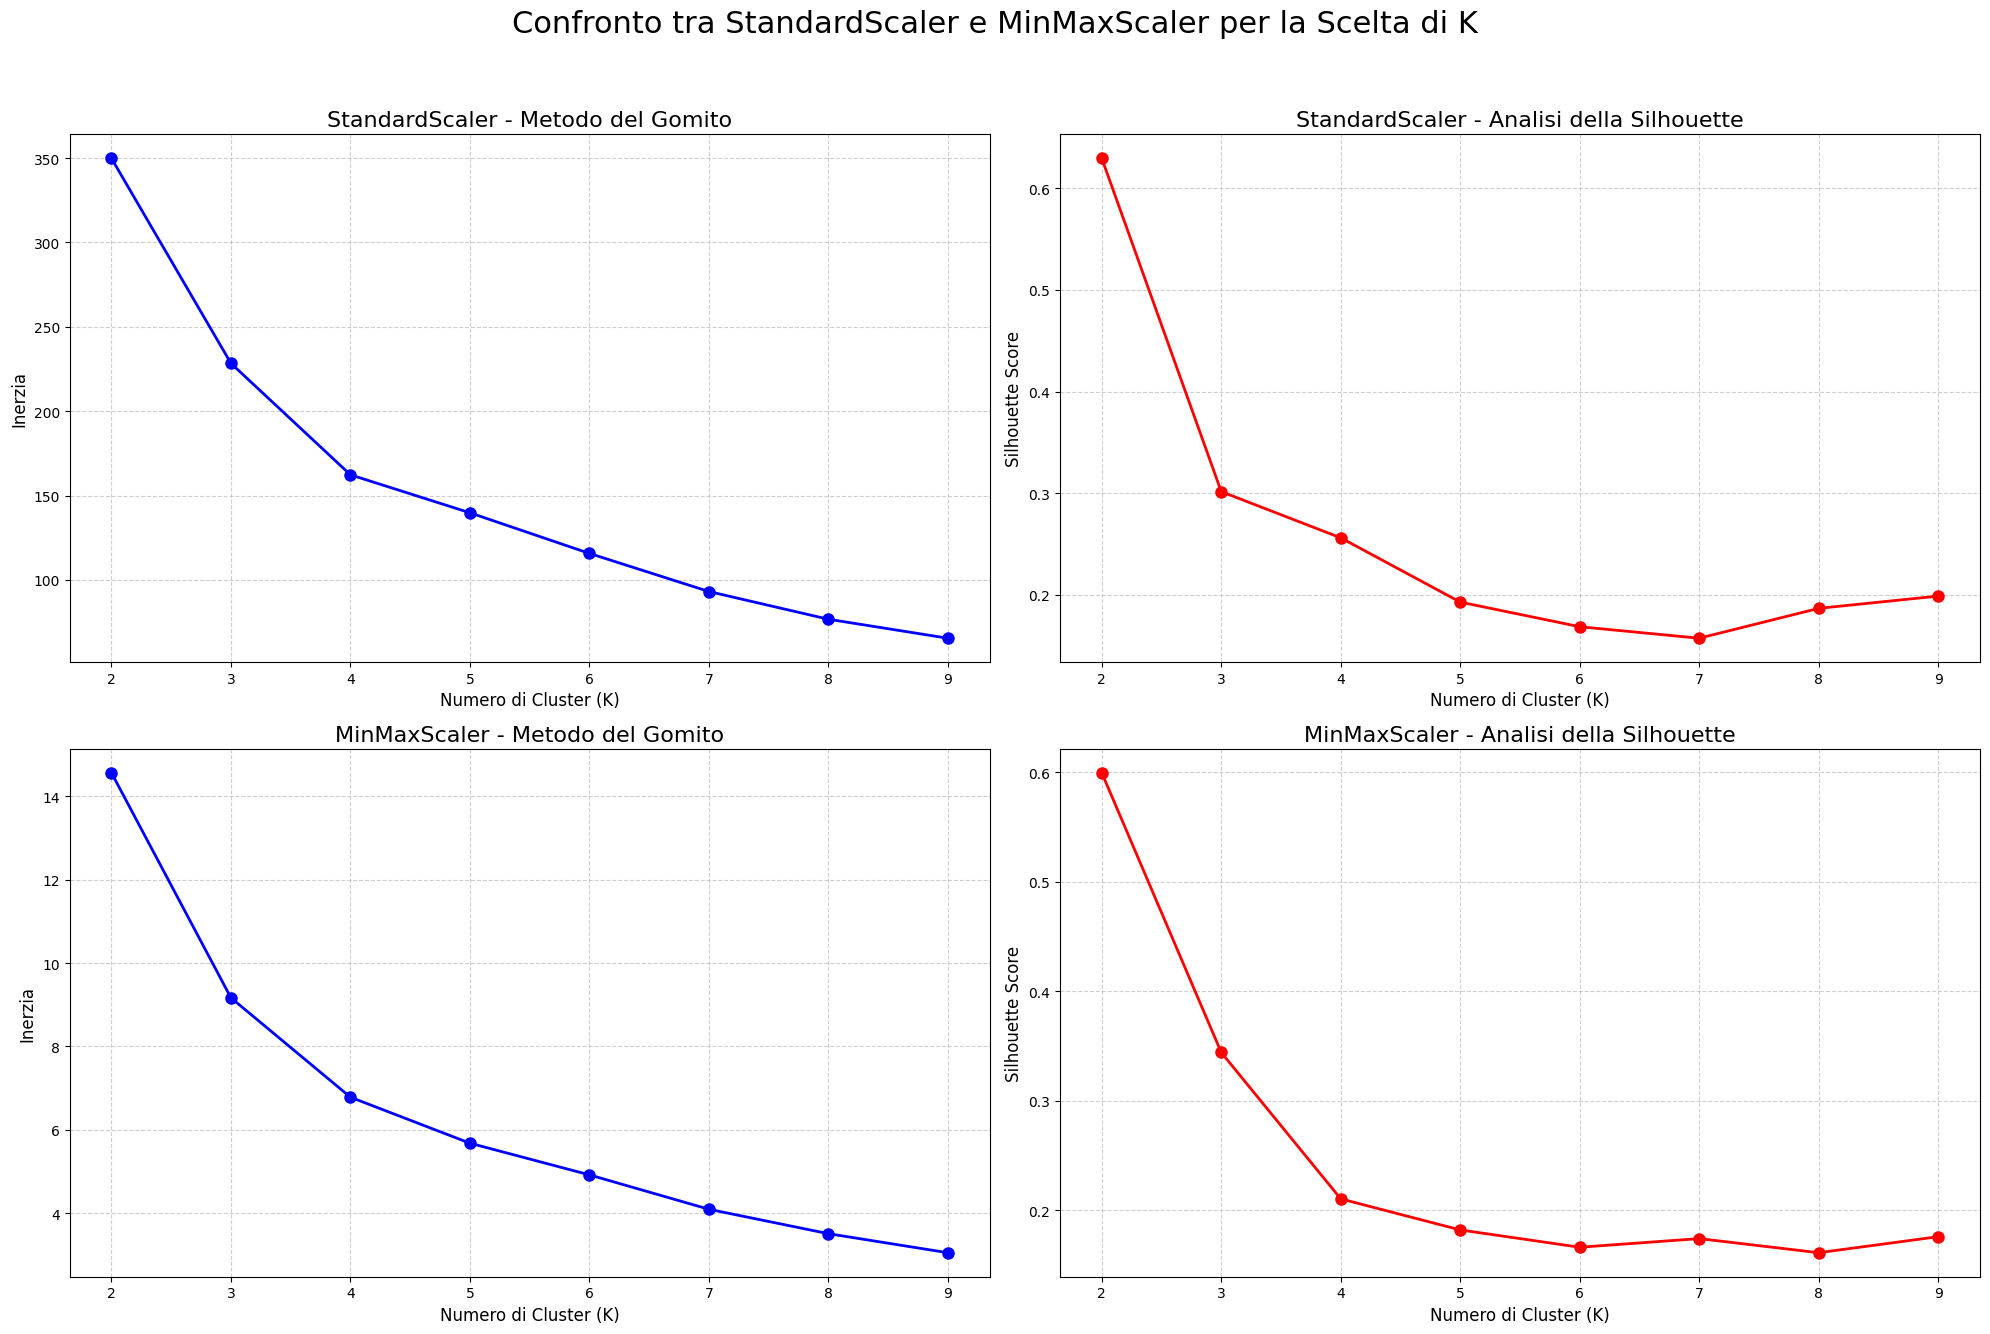


Visualizzazione completata.


In [20]:
print("\n[Passo 4] Creazione della visualizzazione comparativa...")

# Creiamo una figura e una griglia di subplot 2x2.
# figsize è impostato per avere una buona leggibilità.
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Confronto tra StandardScaler e MinMaxScaler per la Scelta di K', fontsize=22)

# --- Riga Superiore: StandardScaler ---

# Grafico 1 (in alto a sinistra): Gomito con StandardScaler
ax[0, 0].plot(k_range, inertias_std, 'bo-', linewidth=2, markersize=8)
ax[0, 0].set_title('StandardScaler - Metodo del Gomito', fontsize=16)
ax[0, 0].set_xlabel('Numero di Cluster (K)', fontsize=12)
ax[0, 0].set_ylabel('Inerzia', fontsize=12)
ax[0, 0].grid(True, linestyle='--', alpha=0.6)

# Grafico 2 (in alto a destra): Silhouette con StandardScaler
ax[0, 1].plot(k_range, silhouette_scores_std, 'ro-', linewidth=2, markersize=8)
ax[0, 1].set_title('StandardScaler - Analisi della Silhouette', fontsize=16)
ax[0, 1].set_xlabel('Numero di Cluster (K)', fontsize=12)
ax[0, 1].set_ylabel('Silhouette Score', fontsize=12)
ax[0, 1].grid(True, linestyle='--', alpha=0.6)

# --- Riga Inferiore: MinMaxScaler ---

# Grafico 3 (in basso a sinistra): Gomito con MinMaxScaler
ax[1, 0].plot(k_range, inertias_mm, 'bo-', linewidth=2, markersize=8)
ax[1, 0].set_title('MinMaxScaler - Metodo del Gomito', fontsize=16)
ax[1, 0].set_xlabel('Numero di Cluster (K)', fontsize=12)
ax[1, 0].set_ylabel('Inerzia', fontsize=12)
ax[1, 0].grid(True, linestyle='--', alpha=0.6)

# Grafico 4 (in basso a destra): Silhouette con MinMaxScaler
ax[1, 1].plot(k_range, silhouette_scores_mm, 'ro-', linewidth=2, markersize=8)
ax[1, 1].set_title('MinMaxScaler - Analisi della Silhouette', fontsize=16)
ax[1, 1].set_xlabel('Numero di Cluster (K)', fontsize=12)
ax[1, 1].set_ylabel('Silhouette Score', fontsize=12)
ax[1, 1].grid(True, linestyle='--', alpha=0.6)

# Migliora la spaziatura tra i grafici per evitare sovrapposizioni
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostra il grafico finale
plt.show()

print("\nVisualizzazione completata.")

---
### Analisi dei Risultati e Scelta Strategica di K

L'analisi dei grafici fornisce indicazioni molto chiare e interessanti sulla struttura latente dei nostri dati.

*   **Dal Metodo del Gomito (grafico a sinistra):** Si osserva una chiara flessione nella curva di Inertia intorno a **K=8**. Dopo questo punto, la riduzione dell'inerzia (visibile anche dalle barre grigie del "delta") diventa molto meno pronunciata, suggerendo che aggiungere ulteriori cluster non porta a un guadagno di compattezza altrettanto significativo.

*   **Dal Punteggio di Silhouette (grafico a destra):** L'analisi rivela due picchi di particolare interesse. Il massimo assoluto si trova a **K=2**, indicando che la divisione più netta in assoluto è in due soli super-gruppi. Tuttavia, si nota un secondo picco locale molto forte a **K=8**, seguito da un altro candidato a **K=16** con un punteggio quasi identico. Dopo K=16, la qualità strutturale dei cluster inizia a diminuire costantemente.

**Decisione Strategica:**

Abbiamo due candidati eccellenti per un'analisi dettagliata: K=8 e K=16. Entrambi rappresentano soluzioni in cui i cluster sono di alta qualità. Tuttavia, per l'ambito di questo progetto di tesi, è fondamentale bilanciare la granularità dell'analisi con la fattibilità dell'interpretazione. Un'analisi approfondita di 16 cluster richiederebbe uno sforzo significativamente maggiore.

Pertanto, per garantire un'analisi dettagliata e ben argomentata di ogni gruppo scoperto, **si sceglie di procedere con K=8**. Questo valore rappresenta un ottimo compromesso, essendo supportato da entrambe le metriche e permettendo una caratterizzazione ricca ma gestibile.

---
### Prossimi Passaggi del Gold Layer

Ora che abbiamo preso la nostra decisione su `K`, il percorso per completare il Gold Layer è definito:

1.  **Fase 5: Addestramento del Modello Finale e Tracciamento su MLflow:** Eseguiremo K-Means un'ultima volta con `n_clusters=8`. L'intero esperimento, inclusi i parametri finali, le metriche e il modello stesso, verrà registrato su MLflow per garantire la riproducibilità.

2.  **Fase 6: Creazione della Tabella Gold:** Aggiungeremo i risultati del clustering (le etichette da 0 a 7) alla nostra tabella dei profili e salveremo questo DataFrame finale e arricchito su MinIO S3 come `stazioni_con_cluster_gold`.

3.  **Fase 7: Analisi e Interpretazione dei Cluster:** Questa sarà la fase finale e più importante, in cui analizzeremo le caratteristiche medie di ogni cluster per dar loro un nome e un significato, completando così la nostra tassonomia comportamentale.